### Data Visualization

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def parse_wflw_annotations(annotation_file, images_dir):
    """
    Parse WFLW annotation files to extract image paths, bounding boxes, and landmarks.

    Args:
        annotation_file (str): Path to the annotation file.
        images_dir (str): Path to the root images directory.

    Returns:
        List[Dict]: A list of dictionaries containing 'image_path', 'bbox', 'landmarks'.
    """
    data = []
    with open(annotation_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Extract the relative image path
            relative_image_path = parts[-1]
            # Construct the full image path
            image_path = os.path.join(images_dir, relative_image_path)
            # Extract landmarks
            landmarks = np.array(parts[:196], dtype=float).reshape(-1, 2)  # 98 landmarks
            # Extract bounding box
            bbox = np.array(parts[196:200], dtype=float)  # bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max

            # Append parsed data
            data.append({
                'image_path': image_path,
                'bbox': bbox,
                'landmarks': landmarks
            })
    return data

In [3]:
def display_image_with_landmarks(data_sample):
    """
    Display an image with landmarks and bounding box.

    Args:
        data_sample (Dict): A single parsed data sample with 'image_path', 'bbox', and 'landmarks'.
    """
    # Check if file exists
    if not os.path.exists(data_sample['image_path']):
        print(f"File not found: {data_sample['image_path']}")
        return

    # Read the image
    image = cv2.imread(data_sample['image_path'])
    if image is None:
        print(f"Failed to load image: {data_sample['image_path']}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bbox = data_sample['bbox']
    landmarks = data_sample['landmarks']

    # Draw the bounding box
    x_min, y_min, x_max, y_max = bbox.astype(int)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Draw landmarks
    for (lx, ly) in landmarks.astype(int):
        cv2.circle(image, (lx, ly), 2, (0, 255, 0), -1)

    # Show the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Landmarks and Bounding Box")
    plt.show()

Total training samples: 7500
{'image_path': './WFLW/WFLW_images\\51--Dresses/51_Dresses_wearingdress_51_377.jpg', 'bbox': array([306., 308., 696., 870.]), 'landmarks': array([[309.307007, 538.369019],
       [317.857345, 560.120847],
       [322.271739, 583.014395],
       [319.583872, 606.149851],
       [314.765287, 629.015727],
       [313.308619, 652.33149 ],
       [315.648163, 675.558182],
       [322.526266, 697.876907],
       [331.880068, 719.301121],
       [342.087363, 740.336765],
       [352.822689, 761.107391],
       [363.917162, 781.689357],
       [374.35333 , 802.607217],
       [383.434488, 824.152584],
       [393.923435, 845.012933],
       [410.131531, 861.653107],
       [431.559411, 870.597153],
       [463.665456, 870.444454],
       [494.908844, 862.408332],
       [525.060623, 850.878448],
       [554.767143, 838.22663 ],
       [583.901545, 824.323471],
       [611.315726, 807.31818 ],
       [635.222521, 785.701484],
       [654.409992, 759.788921],
       

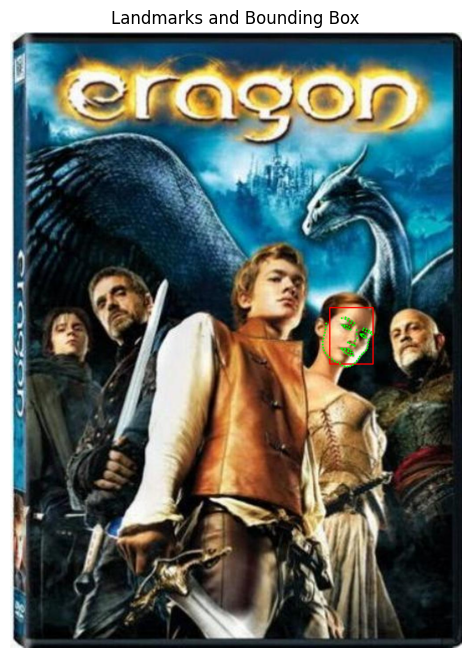

In [4]:
# Directories
images_directory = "./WFLW/WFLW_images"
annotations_file = "./WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"

# Parse the annotations
train_data = parse_wflw_annotations(annotations_file, images_directory)
print(f"Total training samples: {len(train_data)}")
print(train_data[0])

# Display a random sample
import random
sample = random.choice(train_data)
display_image_with_landmarks(sample)


### Data Pre-processing

In [5]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class WFLWDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (List[Dict]): Parsed WFLW data.
            transform (callable, optional): Optional transforms for images.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = cv2.imread(sample['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        # Normalize landmarks and bounding box
        landmarks = sample['landmarks'] / [width, height]  # Normalize (0 to 1)
        bbox = sample['bbox'] / [width, height, width, height]

        # Resize image to 224x224
        image = cv2.resize(image, (224, 224))
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0,1]

        return image, {
            'landmarks': torch.tensor(landmarks.flatten(), dtype=torch.float32),
            'bbox': torch.tensor(bbox, dtype=torch.float32)
        }


### Model Creation

In [6]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetFaceModel(nn.Module):
    def __init__(self, num_landmarks=98):
        super(EfficientNetFaceModel, self).__init__()
        self.num_landmarks = num_landmarks

        # Load EfficientNet backbone
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.backbone_out = 1280  # Output feature size for EfficientNet-B0

        # Bounding Box Head
        self.bbox_head = nn.Sequential(
            nn.Linear(self.backbone_out, 512),
            nn.ReLU(),
            nn.Linear(512, 4)  # 4 values: x_min, y_min, x_max, y_max
        )

        # Landmark Head
        self.landmark_head = nn.Sequential(
            nn.Linear(self.backbone_out, 512),
            nn.ReLU(),
            nn.Linear(512, num_landmarks * 2)  # 196 values: 98 (x, y) pairs
        )

    def forward(self, x):
        # Extract features using EfficientNet backbone
        features = self.backbone.extract_features(x)
        pooled_features = torch.nn.functional.adaptive_avg_pool2d(features, 1).view(x.size(0), -1)

        # Forward pass through heads
        bbox = self.bbox_head(pooled_features)
        landmarks = self.landmark_head(pooled_features)

        return bbox, landmarks


### Training

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# EfficientNet Model Class
class EfficientNetFaceModel(nn.Module):
    def __init__(self, num_landmarks=98):
        super(EfficientNetFaceModel, self).__init__()
        self.num_landmarks = num_landmarks
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.backbone_out = 1280  # EfficientNet-B0 output size

        # Bounding Box Head
        self.bbox_head = nn.Sequential(
            nn.Linear(self.backbone_out, 512),
            nn.ReLU(),
            nn.Linear(512, 4)  # [x_min, y_min, x_max, y_max]
        )

        # Landmark Head
        self.landmark_head = nn.Sequential(
            nn.Linear(self.backbone_out, 512),
            nn.ReLU(),
            nn.Linear(512, num_landmarks * 2)  # 98 landmarks * 2 (x, y)
        )

    def forward(self, x):
        features = self.backbone.extract_features(x)
        pooled_features = torch.nn.functional.adaptive_avg_pool2d(features, 1).view(x.size(0), -1)
        bbox = self.bbox_head(pooled_features)
        landmarks = self.landmark_head(pooled_features)
        return bbox, landmarks

# Instantiate Model
model = EfficientNetFaceModel().to(device)

# Loss Functions
bbox_criterion = nn.MSELoss()
landmark_criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Data Loader
train_loader = DataLoader(WFLWDataset(train_data), batch_size=16, shuffle=True)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        bbox = labels['bbox'].to(device)
        landmarks = labels['landmarks'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        pred_bbox, pred_landmarks = model(images)

        # Compute losses
        loss_bbox = bbox_criterion(pred_bbox, bbox)
        loss_landmarks = landmark_criterion(pred_landmarks, landmarks)
        loss = loss_bbox + loss_landmarks

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save the trained model
model_save_path = "./efficientnet_face_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Loaded pretrained weights for efficientnet-b0
Epoch [1/10], Loss: 0.0847
Epoch [2/10], Loss: 0.0591
Epoch [3/10], Loss: 0.0528
Epoch [4/10], Loss: 0.0485
Epoch [5/10], Loss: 0.0456
Epoch [6/10], Loss: 0.0435
Epoch [7/10], Loss: 0.0415
Epoch [8/10], Loss: 0.0404
Epoch [9/10], Loss: 0.0392
Epoch [10/10], Loss: 0.0384
Model saved to ./efficientnet_face_model.pth


In [8]:
# Paths
images_directory = "./WFLW/WFLW_images"
train_annotations_file = "./WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"
test_annotations_file = "./WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt"

# Parse training and test data
train_data = parse_wflw_annotations(train_annotations_file, images_directory)
test_data = parse_wflw_annotations(test_annotations_file, images_directory)

print(f"Total training samples: {len(train_data)}")
print(f"Total test samples: {len(test_data)}")

# Define Datasets and DataLoaders
train_dataset = WFLWDataset(train_data)
test_dataset = WFLWDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Verify Test DataLoader
for images, labels in test_loader:
    print("Test Image Batch Shape:", images.shape)
    print("Test Landmark Batch Shape:", labels['landmarks'].shape)
    print("Test BBox Batch Shape:", labels['bbox'].shape)
    break


Total training samples: 7500
Total test samples: 2500
Test Image Batch Shape: torch.Size([16, 3, 224, 224])
Test Landmark Batch Shape: torch.Size([16, 196])
Test BBox Batch Shape: torch.Size([16, 4])


### Evaluation

In [11]:
# Evaluate model on test data
model.eval()
total_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        bbox = labels['bbox'].to(device)
        landmarks = labels['landmarks'].to(device)

        pred_bbox, pred_landmarks = model(images)

        loss_bbox = bbox_criterion(pred_bbox, bbox)
        loss_landmarks = landmark_criterion(pred_landmarks, landmarks)
        loss = loss_bbox + loss_landmarks

        total_loss += loss.item()

print(f"Average Test Loss: {total_loss / len(test_loader):.4f}")


Average Test Loss: 0.0828


### Visualization

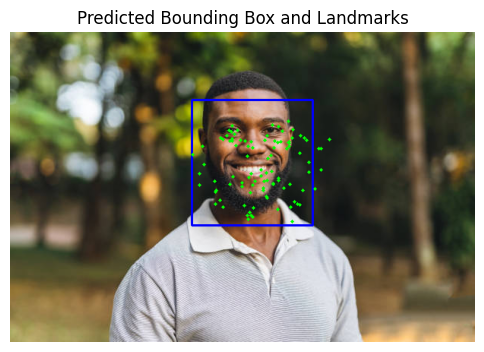

In [14]:
def predict_on_custom_image(image_path, model):
    """
    Predict bounding box and landmarks on a custom image.
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = image.shape[:2]

    # Preprocess the image
    image_resized = cv2.resize(image_rgb, (224, 224))
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        pred_bbox, pred_landmarks = model(image_tensor)

    # Denormalize bounding box and landmarks
    bbox = pred_bbox[0].cpu().numpy() * np.array([original_width, original_height, original_width, original_height])
    landmarks = pred_landmarks[0].cpu().numpy().reshape(-1, 2)
    landmarks = landmarks * np.array([original_width, original_height])

    # Draw results
    x_min, y_min, x_max, y_max = bbox.astype(int)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    for (lx, ly) in landmarks.astype(int):
        cv2.circle(image, (lx, ly), 2, (0, 255, 0), -1)

    plt.figure(figsize=(6, 6))
    plt.imshow(image[:, :, ::-1])
    plt.axis('off')
    plt.title("Predicted Bounding Box and Landmarks")
    plt.show()

# Test on a custom image
custom_image_path = "./img.png"
predict_on_custom_image(custom_image_path, model)
